In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq
import math

# ==========================================
# 1. TẠO MẠNG LƯỚI (GRID GRAPH)
# ==========================================
width, height = 30, 30
G = nx.grid_2d_graph(width, height)

# Gán trọng số (Weight) cho cạnh = 1.0
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1.0

# Lấy tọa độ để vẽ
pos = {node: node for node in G.nodes()}

# ==========================================
# 2. SINH DỮ LIỆU GIẢ LẬP
# ==========================================
def get_nearby_nodes(center_node, radius, count):
    candidates = []
    for node in G.nodes():
        dist = abs(node[0] - center_node[0]) + abs(node[1] - center_node[1])
        if dist <= radius:
            candidates.append(node)
    return random.sample(candidates, min(len(candidates), count))

data_nodes = []
# Tạo 3 cụm
data_nodes.extend(get_nearby_nodes((5, 5), radius=4, count=50))
data_nodes.extend(get_nearby_nodes((25, 25), radius=4, count=40))
data_nodes.extend(get_nearby_nodes((15, 15), radius=3, count=20))
# Tạo Nhiễu
all_nodes = list(G.nodes())
noise_points = random.sample(all_nodes, 40)
data_nodes.extend(noise_points)

# Xóa trùng lặp
data_nodes = list(set(data_nodes))
n_samples = len(data_nodes)

print(f"Tổng số điểm dữ liệu: {n_samples}")

Tổng số điểm dữ liệu: 137


In [2]:
# ==========================================
# 3. THUẬT TOÁN NS-DBSCAN GỐC (ORIGINAL)
# ==========================================

# --- ALGO 1 GỐC: Tìm hàng xóm ---
# KHÔNG CÓ CẮT TỈA (No Pruning): Chạy trên G đầy đủ
def get_network_neighbors_original(G, start_node, eps):
    distances = {start_node: 0}
    queue = [(0, start_node)]
    neighbors = []

    while queue:
        current_dist, u = heapq.heappop(queue)

        # Điều kiện dừng cơ bản
        if current_dist > eps:
            continue
        
        # Nếu là điểm dữ liệu -> Thêm vào hàng xóm
        if u in data_set_lookup: 
            neighbors.append(u)

        # DUYỆT TRÊN ĐỒ THỊ GỐC (G)
        # Nếu đồ thị có cạnh trọng số lớn (ví dụ 1000), vòng lặp này vẫn phải xét nó
        for v in G.neighbors(u):
            weight = G[u][v]['weight']
            new_dist = current_dist + weight
            
            if new_dist <= eps:
                if new_dist < distances.get(v, float('inf')):
                    distances[v] = new_dist
                    heapq.heappush(queue, (new_dist, v))
    return neighbors

# --- HÀM CHÍNH GỐC ---
def run_ns_dbscan_original(G, data_points, eps, min_pts):
    global data_set_lookup
    data_set_lookup = set(data_points)
    
    # [KHÔNG CÓ]: Bước cắt tỉa đồ thị (Pruning)
    
    # --- GIAI ĐOẠN 1: TÍNH MẬT ĐỘ ---
    print("Original: Đang tính toán mật độ cho TOÀN BỘ điểm...")
    ordered_list = []
    point_neighbors_cache = {}

    # [KHÔNG CÓ]: Bộ lọc Heuristic ln(n)
    # Phải chạy vòng lặp cho tất cả các điểm (bao gồm cả Nhiễu)
    for p in data_points:
        nbrs = get_network_neighbors_original(G, p, eps)
        density = len(nbrs)
        
        # Lưu tất cả vào danh sách
        ordered_list.append((density, p))
        point_neighbors_cache[p] = nbrs 

    # Sắp xếp danh sách (Danh sách này dài hơn bản cải tiến rất nhiều)
    ordered_list.sort(key=lambda x: x[0], reverse=True)
    
    # --- GIAI ĐOẠN 2: HÌNH THÀNH CỤM ---
    print("Original: Đang gom cụm (Có xử lý Nhiễu thủ công)...")
    
    # Định nghĩa hằng số trạng thái
    NOISE = -1
    
    labels = {} # Lưu trữ: Cluster_ID hoặc NOISE
    cluster_id = 0
    
    for density, p in ordered_list:
        # Nếu p đã có nhãn (thuộc Cụm hoặc là Noise trước đó) -> Bỏ qua
        if p in labels:
            continue
            
        neighbors = point_neighbors_cache[p]
        
        # [QUY TRÌNH GỐC]: Kiểm tra MinPts
        if len(neighbors) < min_pts:
            # Gán nhãn NOISE rõ ràng (Bản cải tiến bỏ bước này)
            labels[p] = NOISE 
        else:
            # Bắt đầu cụm mới
            cluster_id += 1
            labels[p] = cluster_id
            
            # Mở rộng cụm (Expand Cluster)
            seeds = list(neighbors)
            i = 0
            while i < len(seeds):
                q = seeds[i]
                
                if q in labels:
                    # [LOGIC GỐC]: Xử lý điểm biên
                    # Nếu q trước đó bị gán là NOISE, giờ nó được "cứu" thành điểm biên
                    if labels[q] == NOISE:
                        labels[q] = cluster_id
                    # Nếu q đã thuộc cụm khác -> Giữ nguyên, không làm gì
                else:
                    # Nếu q chưa có nhãn -> Gán vào cụm
                    labels[q] = cluster_id
                    
                    # Tính hàng xóm của q để xem có mở rộng tiếp được không
                    # (Ở đây dùng cache nếu có, hoặc tính lại)
                    if q in point_neighbors_cache:
                        q_neighbors = point_neighbors_cache[q]
                    else:
                        q_neighbors = get_network_neighbors_original(G, q, eps)
                    
                    if len(q_neighbors) >= min_pts:
                        seeds.extend(q_neighbors)
                
                i += 1
    
    return labels

In [3]:
# Cấu hình tham số
EPS = 1.5
MIN_PTS = 4

# Chạy thuật toán Gốc
labels_original = run_ns_dbscan_original(G, data_nodes, EPS, MIN_PTS)

# Thống kê
n_noise = list(labels_original.values()).count(-1)
n_clustered = len(labels_original) - n_noise
print(f"\nKẾT QUẢ:")
print(f"- Tổng số điểm: {n_samples}")
print(f"- Điểm thuộc cụm: {n_clustered}")
print(f"- Điểm nhiễu (NOISE): {n_noise}")

Original: Đang tính toán mật độ cho TOÀN BỘ điểm...
Original: Đang gom cụm (Có xử lý Nhiễu thủ công)...

KẾT QUẢ:
- Tổng số điểm: 137
- Điểm thuộc cụm: 99
- Điểm nhiễu (NOISE): 38


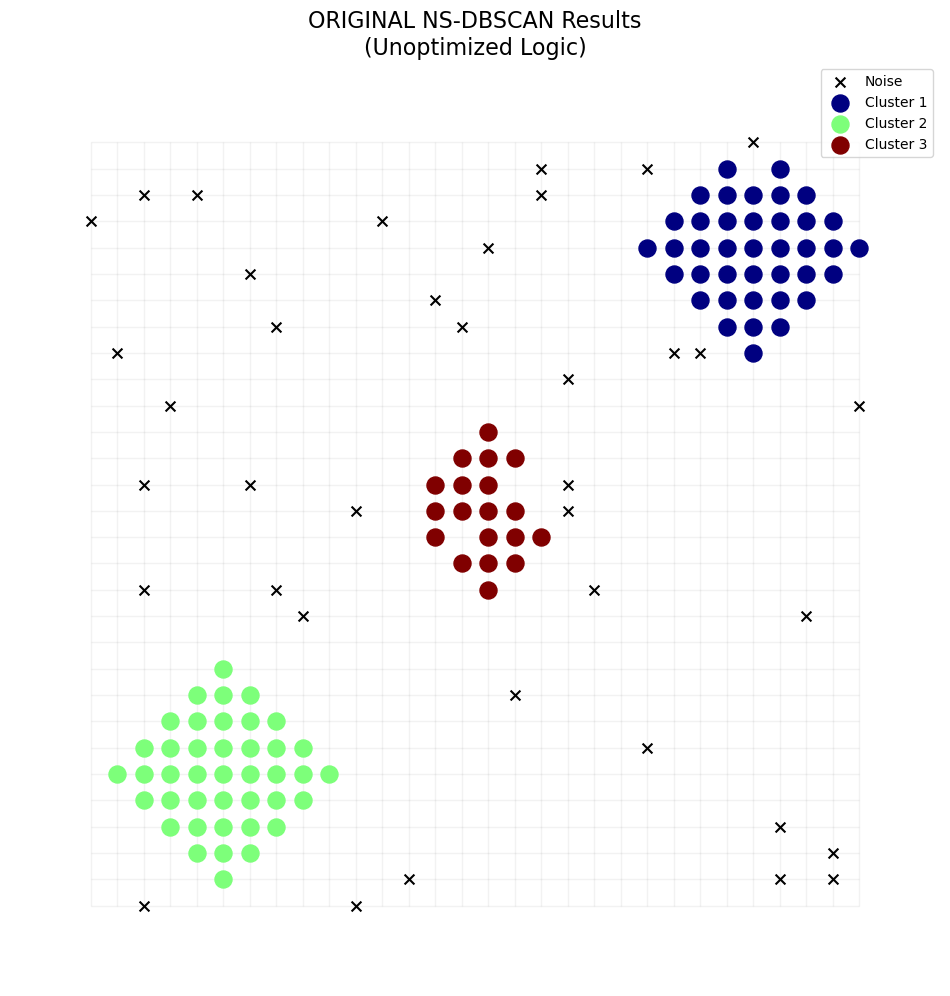

In [4]:
# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(12, 12))

# Vẽ nền bản đồ mờ
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# Tách dữ liệu để vẽ
clusters = {}
noise_nodes = []

for p, label in labels_original.items():
    if label == -1: # Nhãn NOISE
        noise_nodes.append(p)
    else:
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(p)

# Vẽ Nhiễu
if noise_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=noise_nodes, 
                           node_color='black', node_size=50, node_shape='x', label='Noise')

# Vẽ Cụm
colors = plt.cm.jet(np.linspace(0, 1, len(clusters)))
for i, c_id in enumerate(clusters.keys()):
    nodes = clusters[c_id]
    col = colors[i]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                           node_color=[col], node_size=150, node_shape='o', label=f'Cluster {c_id}')

plt.title(f"ORIGINAL NS-DBSCAN Results\n(Unoptimized Logic)", fontsize=16)
plt.legend()
plt.axis('off')
plt.show()